# 07 t-Test - Task 2

Provide a script and html file which calulates the suitable T-Tests to answer the following research questions (RQ). Please also test the requirements for each test, and, report the results in one sentence including the test statistic value with degree of freedom, significance value as well as effect size.

2.RQ (regarding DB03): Does the test environment (independent variable), i.e. Lab (ID=1) or home (ID=0), have a significant influence on speech quality ratings (dependent variable). Use the quality ratings of condition 3 provided in the file (lab_crowd_speech_quality).

## Import and Initializing

In [8]:
import numpy as np
import pandas as pd

import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="talk")

FIGSIZE = (20,4)

## Load and visualize dataset

In [9]:
dataset = pd.read_excel("../datasets/DB03_lab_crowd_speech_quality.xlsx")
dataset

,Environment,Quality
0,0,4
1,0,3
2,0,4
3,0,4
4,0,4
...,...,...
400,1,2
401,1,2
402,1,3
403,1,1


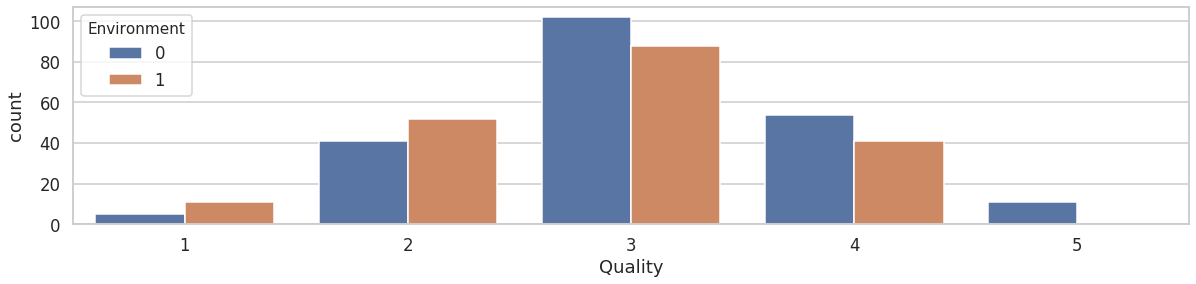

In [10]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.countplot(x="Quality",  hue="Environment", data=dataset, ax=ax)
None

## Test Requirements
### Measurement Level
> dependent variable should be measured at the interval or ratio level (i.e., continuous)

The provided quality values are measured on the _interval_ level. ✓
### No significant outliers
Check for outliers via boxplot:

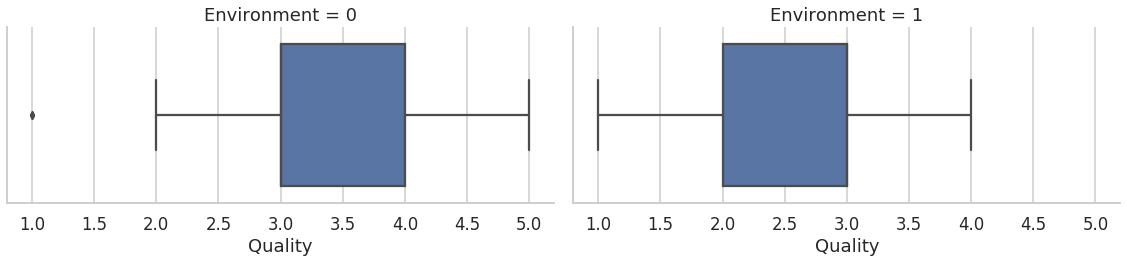

In [11]:
g = sns.FacetGrid(dataset, col="Environment", height=4, aspect=2)
g.map_dataframe(sns.boxplot, "Quality")
g.fig.tight_layout()

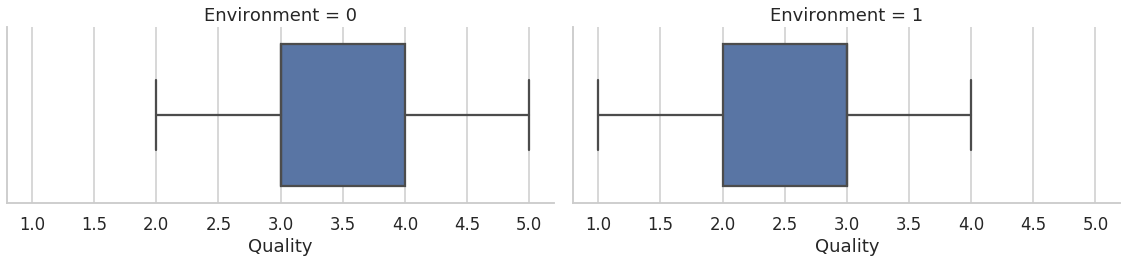

In [12]:
# Select mask with all outliers, and invert it to filter outliers
outlier_mask = (dataset.Environment == 0) & (dataset.Quality == 1)
dataset_no_outliers = dataset.loc[~outlier_mask]

# Plot cleaned dataset
g = sns.FacetGrid(dataset_no_outliers, col="Environment", height=4, aspect=2)
g.map_dataframe(sns.boxplot, "Quality")
g.fig.tight_layout()

Outliers removed ✓

### Independent Groups
> independent variable should consist of two categorical, independent groups

Since data for each _Environment_ was measure using a disjoint group of subjects, the _Environment_ separates the data into two categorical, independent groups. ✓

### Independence of Observations
?

### Approx. Normal Distribution
> dependent variable should be approximately normally distributed for each group of the independent variable

See histrogram at the top. ✓

### Homogeneity of Variances

> The Levene test tests the null hypothesis that all input samples are from populations with equal variances. [...]
> Notes
Three variations of Levene’s test are possible. The possibilities and their recommended usages are:
- ‘median’ : Recommended for skewed (non-normal) distributions>
- ‘mean’ : Recommended for symmetric, moderate-tailed distributions.
- ‘trimmed’ : Recommended for heavy-tailed distributions.

Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

We assume an approximate normal distribution. Therefore, we use the `mean` approach.

In [13]:
home = dataset_no_outliers[dataset_no_outliers.Environment == 0].Quality
lab = dataset_no_outliers[dataset_no_outliers.Environment == 1].Quality

levene_result = scipy.stats.levene(home, lab, center="mean")
print(f"Levene p-value: {levene_result.pvalue}")
has_equal_var = levene_result.pvalue > 0.05

Levene p-value: 0.5180100399464473


The resulting p-value is (much) larger than 0.05, therefore we cannot reject the null-hypothesis. The homogeneity of variances is given. ✓

## Independent T-test

> Calculate the T-test for the means of two independent samples of scores.<br/><br/>
> This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In [19]:
ind_ttest_result = scipy.stats.ttest_ind(home, lab, equal_var=has_equal_var)
print("Independent T-test")
print(f"\tt-statistic: {ind_ttest_result.statistic:f}")
print(f"\tp-value: {ind_ttest_result.pvalue:f}")

Independent T-test
	t-statistic: 4.169600
	p-value: 0.000037


The p-value much lower than 0.01 (<1% false-positive rate). Therefore, we can _reject_ the null hypothesis that the two independent groups have _equal_ averages, i.e. **the test environment has a significant influence on speech quality ratings**.

### Degrees of Freedom
> #### Equal or unequal sample sizes, equal variance
> [...]
> In these formulae, $n_i − 1$ is the number of degrees of freedom for each group, and the total sample size minus two (that is, $n_1 + n_2 − 2$) is the total number of degrees of freedom, which is used in significance testing. 

Source: https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes,_equal_variance

In [27]:
n_home = home.size
n_lab = lab.size

dof_home = n_home - 1
dof_lab = n_lab - 1
dof_total = dof_home + dof_lab
assert dof_total == n_home + n_lab - 2

print(f"Degrees of freedom group _home_: {dof_home}")
print(f"Degrees of freedom group _lab_: {dof_lab}")
print(f"Total degrees of freedom: {dof_total}")

Degrees of freedom group _home_: 207
Degrees of freedom group _lab_: 191
Total degrees of freedom: 398


### Effect Size Using Cohen's d
$$d = \frac{\mu_{home} - \mu_{lab}}{s_p}$$
where $\mu_{home}$ and $\mu_lab$ are the averages of their respective independent samples and $s_p$ refers to the pooled standard diviation:<br/>
<br/>
$$s_p = \sqrt{\frac{(n_{home} - 1) s^2_{home} + (n_{lab} - 1) s^2_{lab}}{n_{home} + n_{lab} - 2}}$$
<br/>
where $n_{home}$ and $n_{lab}$ are the number of samples per group, and $s^2_{home}$ and $s^2_{lab}$ to their respective sample variances.

Source: https://en.wikipedia.org/wiki/Effect_size#Cohen's_d

In [28]:
mu_home = home.mean()
mu_lab = lab.mean()

s2_home = home.var()
s2_lab = lab.var()

s_p = np.sqrt((dof_home * s2_home + dof_lab * s2_lab) / dof_total)

d = (mu_home - mu_lab) / s_p

print(f"Cohen's d: {d}")

Cohen's d: 0.41729399676979945


**Conclusion**: This corresponds to a _small_ effect size.